# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число кроків навчання однієї епохи
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x = self.layer_2(x)
    return self.layer_3(x, activation=1)

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.math.argmax(y_pred, axis=1, output_type=tf.dtypes.int32)
    return tf.math.count_nonzero(tf.math.equal(y_pred, y_true), dtype=tf.dtypes.int32)/tf.size(y_true)

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")


# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
    # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

        # Отримаємо список оптимізованих параметрів
        model_parameters = [
                    neural_net.layer_1.w,
                    neural_net.layer_1.b,
                    neural_net.layer_2.w,
                    neural_net.layer_2.b,
                    neural_net.layer_3.w,
                    neural_net.layer_3.b,
                ]
        
        # Обчислимо за ними значення градієнта
        model_gradients = g.gradient(loss, model_parameters)

        # # Обчислимо за ними значення градієнта
        optimizer.apply_gradients(zip(model_gradients, model_parameters))


In [7]:
# Тренування мережі

step_history = []
loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss_value = cross_entropy(pred, batch_y)
        accuracy_value = accuracy(pred, batch_y)
        step_history.append(step)
        loss_history.append(loss_value)
        accuracy_history.append(accuracy_value)

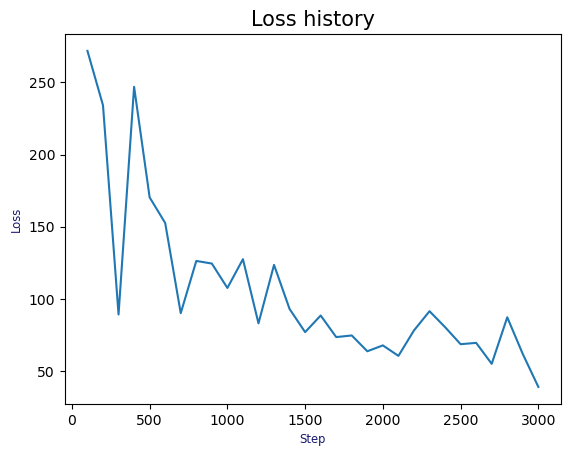

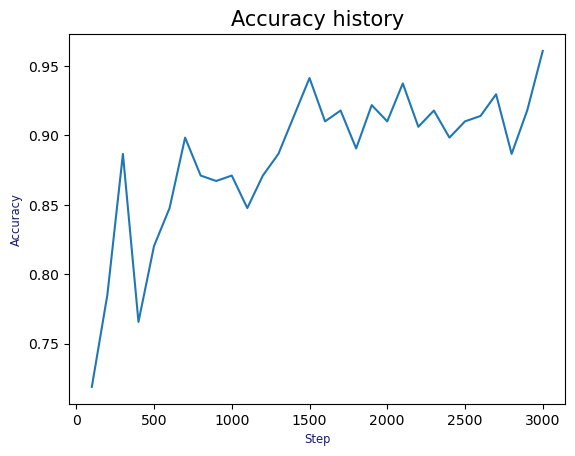

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.xlabel('Step', fontsize='small', color='midnightblue')
plt.ylabel('Loss', fontsize='small', color='midnightblue')
plt.title('Loss history', fontsize=15)
plt.plot(step_history, loss_history)
plt.show()

# Виведіть графік точності
plt.xlabel('Step', fontsize='small', color='midnightblue')
plt.ylabel('Accuracy', fontsize='small', color='midnightblue')
plt.title('Accuracy history', fontsize=15)
plt.plot(step_history, accuracy_history)
plt.show()

In [9]:
# Обчисліть точність навченої нейромережі
print("Оцінка моделі на тренувальній вибірці:")
pred = neural_net(x_train)
accuracy_value = accuracy(pred, y_train)
print(f"Accuracy: {tf.get_static_value(accuracy_value)}")
report = classification_report(y_train, tf.math.argmax(pred, axis=1, output_type=tf.dtypes.int32))
print(report)

# Тестування моделі на тестових даних
print("Оцінка моделі на тестовій вибірці:")
pred = neural_net(x_test)
accuracy_value = accuracy(pred, y_test)
print(f"Accuracy: {tf.get_static_value(accuracy_value)}")
report = classification_report(y_test, tf.math.argmax(pred, axis=1, output_type=tf.dtypes.int32))
print(report)

Оцінка моделі на тренувальній вибірці:
Accuracy: 0.9235333333333333
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5923
           1       0.98      0.97      0.98      6742
           2       0.92      0.91      0.91      5958
           3       0.88      0.91      0.90      6131
           4       0.94      0.91      0.92      5842
           5       0.89      0.89      0.89      5421
           6       0.93      0.96      0.94      5918
           7       0.93      0.95      0.94      6265
           8       0.89      0.88      0.89      5851
           9       0.91      0.89      0.90      5949

    accuracy                           0.92     60000
   macro avg       0.92      0.92      0.92     60000
weighted avg       0.92      0.92      0.92     60000

Оцінка моделі на тестовій вибірці:
Accuracy: 0.9015
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       980
           1

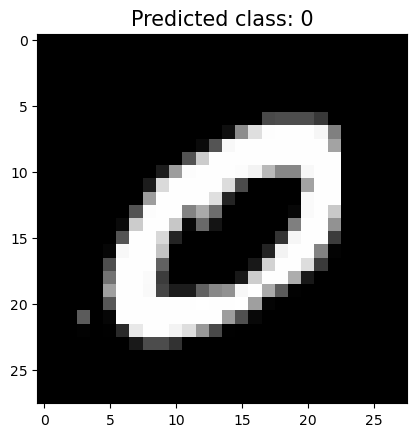

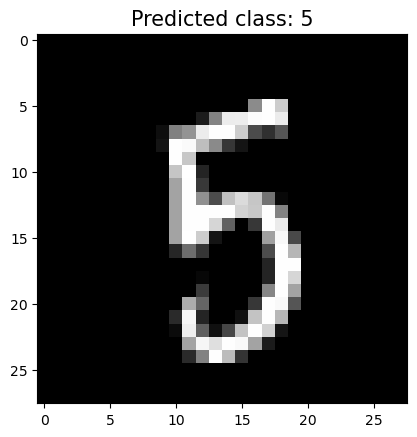

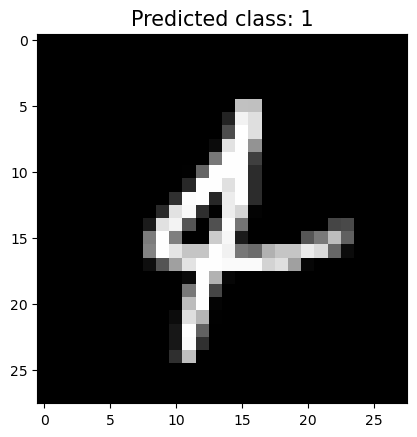

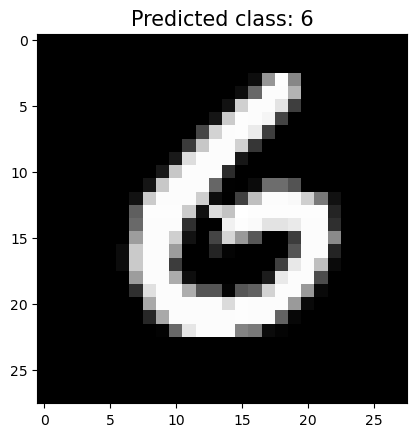

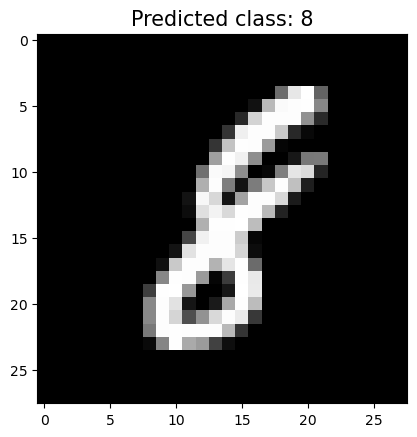

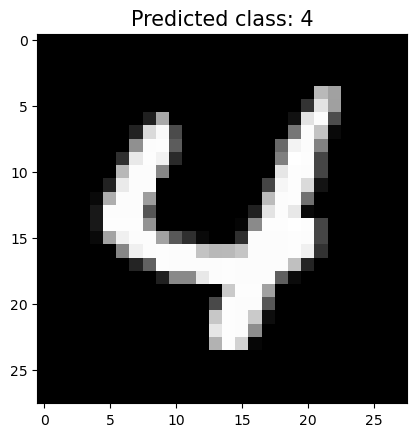

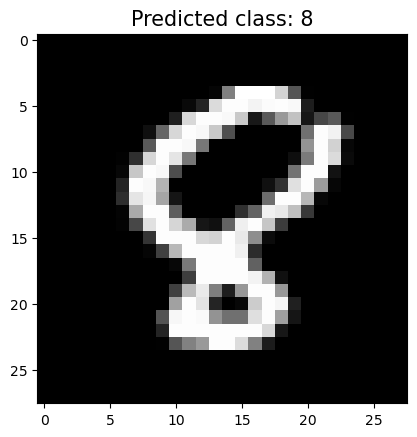

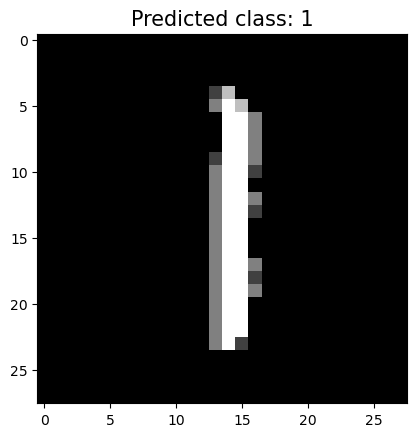

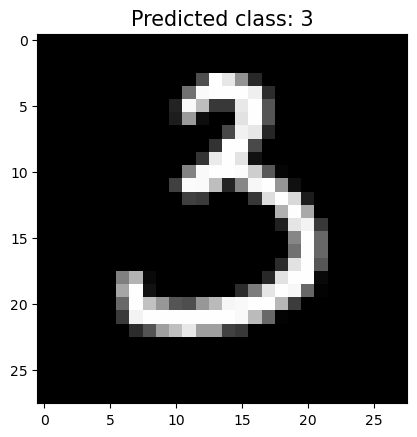

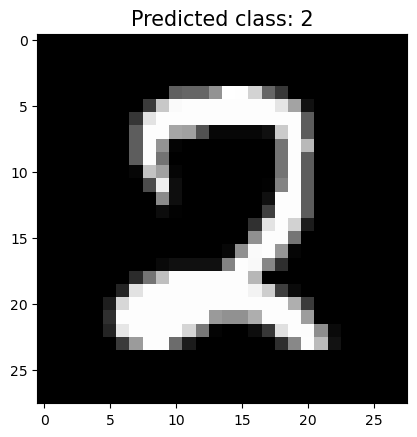

In [11]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Місце для вашого коду
for i in random.sample(range(x_test.shape[0]), 10):
    plt.title(f'Predicted class: {tf.math.argmax(neural_net([x_test[i]]), axis=1, output_type=tf.dtypes.int32)[0]}', fontsize=15)
    plt.imshow(x_test[i].reshape((28, 28)), cmap='gray')
    plt.show()

### Висновок:
Побудувавши модель нейронної мережі та провівши її навчання ми отримали чудовий результат - точність класифікації рукописних цифр більше 92% на навчальній вибірці та більше 90% на тестовій. Тобто ми можемо очікувати, що в середньому наша модель буде помилятися на одному зображенні з десяти, що й підтвердилося вище для десяти випадкових зображень з тестової вибірки (а при повторному запуску ноутбука вам може пощастити, і для інших десяти випадкових зображень модель не помилиться жодного разу). І такий результат отримано за використання доволі простої моделі та однієї епохи навчання, що означає, що потенціал для вдосконалення моделі ще далекий до вичерпання.